# Dictionary learning

* Some images may be naturally sparse under different linear transforms
* We may not know a good transform, can we build one from a set of training images?

We need to solve

$$\min_{z, D} \sum_{i=1}^m \frac{1}{2}\|Dz - u_i\|_2^2 + \alpha \|z\|_1,$$

under suitable constraints on $D$.

In [23]:
from sklearn.decomposition import DictionaryLearning
from sklearn.datasets import load_digits, make_sparse_coded_signal
import matplotlib.pyplot as plt 
import numpy as np

n_train = 100
n_test = 50

digits = load_digits()
U_train = digits.data[:n_train]
U_test = digits.data[n_train:n_train+n_test]

In [2]:
def show_digits(U,m,n):
    fig, ax = plt.subplots(m,n)
    k = 0
    for i in range(m):
        for j in range(n):
            ax[i,j].imshow(U[k,:].reshape(8,8),cmap='gray')
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            k += 1
    fig.tight_layout()

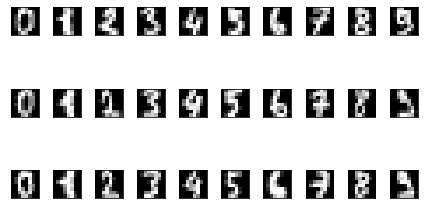

In [3]:
show_digits(U_train[:30],3,10)

In [4]:
# initialise dictionary learner
dict_learner = DictionaryLearning(n_components=15, transform_algorithm='lasso_lars', random_state=42)

# learn dictionary and fit
Z_train = dict_learner.fit_transform(U_train)

In [10]:
# compute sparsity level
print('NNZ:', np.mean(Z_train == 0)/64/n_train)

# compute training error (MSE)
U_hat = Z_train @ dict_learner.components_
print('MSE:', np.mean(np.sum((U_hat - U_train) ** 2, axis=1) / np.sum(U_train ** 2, axis=1)))

NNZ: 5.6770833333333335e-05
MSE: 0.038388440168770396


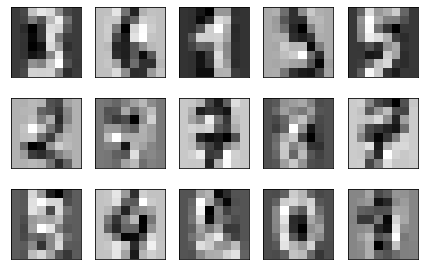

In [11]:
# plot dictionary elements
show_digits(dict_learner.components_,3,5)

In [12]:
# compute testing error
Z_test = dict_learner.transform(U_test)

# compute sparsity level
print('NNZ:', np.mean(Z_test == 0)/64/n_test)

# compute training error (MSE)
U_hat = Z_test @ dict_learner.components_
print('MSE:', np.mean(np.sum((U_hat - U_test) ** 2, axis=1) / np.sum(U_test ** 2, axis=1)))

NNZ: 6.916666666666666e-05
MSE: 0.05904831763475732


See https://scikit-learn.org/stable/auto_examples/decomposition/plot_image_denoising.html

# Assignment: bias-variance

* look at the bias variance trade-off when varying the size of the dictionary

In [118]:
# generate training data
n_train = 100
n_test = 20
U,_,_ = make_sparse_coded_signal(n_samples = n_train + n_test, n_components = 15, n_features = 20, n_nonzero_coefs = 10)
U_train = np.copy(U[:,:n_train].T)
U_test = np.copy(U[:,n_train:n_test+n_train].T)

In [137]:
# helper functions for training and computing the emperical risk
def train(U, k):
    
    # initialise dictionary learner
    dict_learner = DictionaryLearning(n_components=k,transform_n_nonzero_coefs=10, random_state=42)

    # learn dictionary
    dict_learner.fit(U)
    
    #
    return dict_learner

def risk(D, U):
    Z = D.transform(U)
    Uh = Z @ D.components_
    
    return np.mean(np.sum((Uh - U) ** 2, axis=1))

In [138]:
nc = 10
K = np.linspace(10,50,nc,dtype=int)
training_risk = np.zeros(nc)
testing_risk = np.zeros(nc)

for k in range(nc):
    D = train(U_train,K[k])
    training_risk[k] = risk(D, U_train)
    testing_risk[k] = risk(D, U_test)


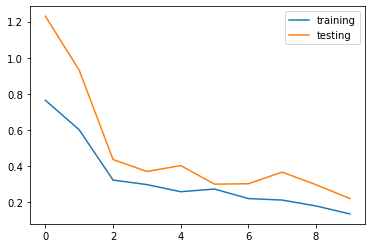

In [139]:
plt.plot(K,training_risk,label='training')
plt.plot(K,testing_risk,label='testing')
plt.legend()

In [144]:
np.linspace(10,50,10,dtype=int)

array([10, 14, 18, 23, 27, 32, 36, 41, 45, 50])